In [ ]:
"""
PROEBLEMs:

validation rn --> change loading images train, we've done it before

Also raro con numero de clases y numero de canales

TODOs:

implement unet with --> segmentation models and transfer learning: https://github.com/qubvel/segmentation_models
different weights to classes, hence, number of clases? --> https://github.com/ianhi/AC295-final-project-JWI/blob/master/lib/Segmentation.py // https://towardsdatascience.com/how-we-built-an-easy-to-use-image-segmentation-tool-with-transfer-learning-546efb6ae98 // https://www.tensorflow.org/tutorials/structured_data/imbalanced_data --> it'll depend on the magnitude of the loss functions
test my model with oxford --> https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet /// https://www.kaggle.com/spidy20/image-segmentation-using-unet-tensorflow
check the activation of layers --> https://awjuliani.medium.com/visualizing-neural-network-layer-activation-tensorflow-tutorial-d45f8bf7bbc4
implement shuffling in the generator --> https://github.com/qubvel/segmentation_models/blob/master/examples/multiclass%20segmentation%20(camvid).ipynb // https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly 
"""

In [3]:
import os
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

#Run from server

gpu4 = "GPU-71b4cdfc-e381-0b98-9b24-4fc06284b496" 
gpu5 = "GPU-99d0769a-9f86-4800-a40e-2320dddcf5d1" 
gpu6 = "GPU-7423cfb5-cff4-ec4d-7e96-ea6e1591d56f"
gpu7 = "GPU-c0a8738f-6dd0-1b78-c38f-4969fd3886a8"

os.environ["CUDA_VISIBLE_DEVICES"]= gpu6 + "," + gpu5

print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:XLA_GPU:1', '/device:GPU:0', '/device:GPU:1']


In [4]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import h5py
import cv2

In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

In [6]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
IMG_DEPTH = 155

IMG_HEIGHT_UNET = 256
IMG_WIDTH_UNET = 256

N_IMG = 369
length_file = IMG_DEPTH * N_IMG
h5py_file_name = 'training.hdf5'
smooth = 1

___

Generating the data and creating data arrays

In [ ]:
ImgDir = os.path.join("..","data","MICCAI_BraTS2020_TrainingData")
features_path = list()
labels_path = list()
count = 0
lim = 10

for folder in os.listdir(ImgDir):
    count +=1
    if 'Training' in folder:
        new_dir = os.path.join(ImgDir,folder)
        data = os.listdir(new_dir)
        for files in data:
            if 'flair' in files:
                features_path.append(os.path.join(new_dir, files))
            if 'seg' in files:
                labels_path.append(os.path.join(new_dir, files))

print(len(features_path))
print(len(labels_path))


In [ ]:
img_conc_features = np.zeros((len(features_path),IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH))
path = features_path

for file, i in zip(path,range(len(path))):
    img = nib.load(file)
    imgarr = img.get_fdata()
    img_conc_features[i,:,:,:] = imgarr
    
img_conc_features = np.concatenate(img_conc_features,axis=2)
print(np.shape(img_conc_features))

In [ ]:
img_conc_labels = np.zeros((len(labels_path),IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH))
path = labels_path

for file, i in zip(path,range(len(path))):
    img = nib.load(file)
    imgarr = img.get_fdata()
    img_conc_labels[i,:,:,:] = imgarr
    
img_conc_labels = np.concatenate(img_conc_labels,axis=2)
print(np.shape(img_conc_labels))

In [ ]:
with h5py.File(os.path.join('..','data',h5py_file_name), 'a') as f:
    f.create_dataset("features", data=img_conc_features, compression="gzip")
    f.create_dataset("labels", data=img_conc_labels, compression="gzip")

In [ ]:
hdf5_store_Brats = h5py.File(os.path.join('..','data',h5py_file_name), "r")
test_img = hdf5_store_Brats["features"][:, :, 100]
plt.imshow(test_img, cmap ='gray')
hdf5_store_Brats.close()

In [ ]:
hdf5_store_Brats = h5py.File(os.path.join('..','data',h5py_file_name), "r")
test_img = hdf5_store_Brats["labels"][:, :, 100]
plt.imshow(test_img, cmap ='gray')
hdf5_store_Brats.close()

___

Load data and model

In [7]:
# images = X_nib.get_fdata()
# labels = y_nib.get_fdata()

#https://www.pythonforthelab.com/blog/how-to-use-hdf5-files-in-python/

with h5py.File(os.path.join('..','data',h5py_file_name), "r") as f:
    #images_train = f["features"][()] #the whole dataset: 57195 images
    #labels_train = f["labels"][()]
    
    images = f["features"]
    images_train = images[:,:,:300] #taking a subsample
    
    labels = f["labels"]
    labels_train = labels[:,:,:300]

batch_size = 30 # 

In [8]:
np.shape(images_train)

(240, 240, 300)

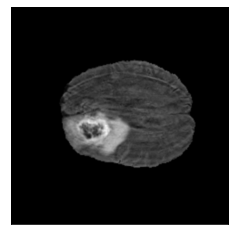

In [9]:
plt.imshow(images_train[:,:,100], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

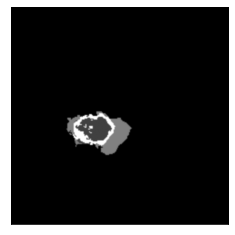

In [10]:
plt.imshow(labels_train[:,:,100], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [11]:
images_train[:,:,100]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

____

In [39]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [40]:
class Dataset:
    
    CLASSES = ['0','1','2','3','4']
    
    def __init__(self, images_train, images_label, classes = None):
        self.images_fps = images_train
        self.masks_fps = images_label
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.ids = len(images_train[1,1,:])
    
    def __getitem__(self, i):
        
        # read data
        image = self.images_fps[:,:,i]
        mask = self.masks_fps[:,:,i]
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
#         if mask.shape[-1] != 1:
#             background = 1 - mask.sum(axis=-1, keepdims=True)
#             mask = np.concatenate((mask, background), axis=-1)
            
        return image, mask
    
    def __len__(self):
        return len(self.ids)

In [41]:
class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)  

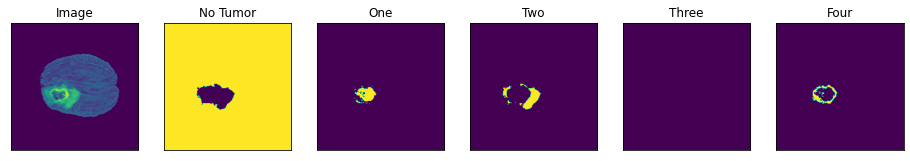

In [42]:
dataset = Dataset(images_train, labels_train, classes=['0','1','2','3','4'])
image, mask = dataset[100]
visualize(
    image=image, 
    no_tumor=mask[..., 0].squeeze(),
    one=mask[..., 1].squeeze(),
    two=mask[..., 2].squeeze(),
    three=mask[..., 3].squeeze(),
    four=mask[..., 4].squeeze(),
)

In [46]:
import segmentation_models as sm

BACKBONE = 'resnet34'
BATCH_SIZE = 8
CLASSES = ['0','1','2','3','4']
LR = 0.0001
EPOCHS = 40

# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES))  # case for binary and multiclass segmentation
# n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

print(n_classes)

5


In [47]:
#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

ResourceExhaustedError: OOM when allocating tensor with shape[7,7,3,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add]

In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [15]:
#https://towardsdatascience.com/using-custom-building-blocks-in-tensorflow-2-0-550b88eb7aa2

class My_Custom_Generator(tf.keras.utils.Sequence):
  
    def __init__(self, images, labels, batch_size, shuffle = False):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(images[1,1,:]))

    def __len__(self) :
        #return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
        return len(self.indexes) // self.batch_size


    def __getitem__(self, idx) :
        batch_x = self.images[:,:,idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[:,:,idx * self.batch_size : (idx+1) * self.batch_size]
        #240,240,32
        batch_x /= 255.
        batch_y /= 255.

#         train_image = np.zeros((batch_size,IMG_HEIGHT,IMG_WIDTH,3))
#         train_label = np.zeros((batch_size,IMG_HEIGHT,IMG_WIDTH,3))
        
        train_image = np.zeros((batch_size,IMG_HEIGHT_UNET,IMG_WIDTH_UNET,3))
        train_label = np.zeros((batch_size,IMG_HEIGHT_UNET,IMG_WIDTH_UNET,3))
        
        for i in range(batch_size):
            
#             X_new = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3), np.float32)
#             y_new = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3), np.float32)

            X_new = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3), np.float32)
            y_new = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3), np.float32)

            X_new[:IMG_HEIGHT,:IMG_WIDTH,0] = batch_x[:,:,i]
            X_new[:IMG_HEIGHT,:IMG_WIDTH,1] = batch_x[:,:,i]
            X_new[:IMG_HEIGHT,:IMG_WIDTH,2] = batch_x[:,:,i]
            
            y_new[:IMG_HEIGHT,:IMG_WIDTH,0] = batch_y[:,:,i]
            y_new[:IMG_HEIGHT,:IMG_WIDTH,1] = batch_y[:,:,i]
            y_new[:IMG_HEIGHT,:IMG_WIDTH,2] = batch_y[:,:,i]
            
#             X_new[:,:,0] = batch_x[:,:,i]
#             X_new[:,:,1] = batch_x[:,:,i]
#             X_new[:,:,2] = batch_x[:,:,i]

#             y_new[:,:,0] = batch_y[:,:,i]
#             y_new[:,:,1] = batch_y[:,:,i]
#             y_new[:,:,2] = batch_y[:,:,i]

            train_image[i,:,:,:] = X_new
            train_label[i,:,:,:] = y_new

           
          # Checking the input images in the network  
            
#         plt.imshow(train_image[10,:,:,1], cmap = 'gray')
#         plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
#         plt.show()
        
#         plt.imshow(train_label[10,:,:,1], cmap = 'gray')
#         plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
#         plt.show()
        
        return np.array(train_image), np.array(train_label)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes) 

my_training_batch_generator = My_Custom_Generator(images_train, labels_train, batch_size)

Correct input in the netowrk

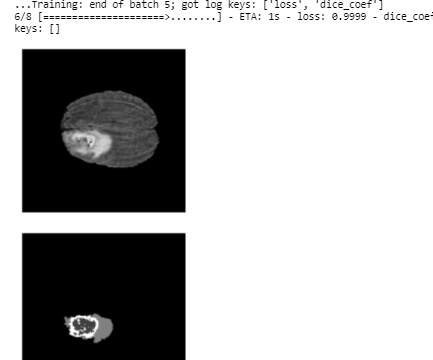

In [16]:
class printbatch(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, epoch, logs={}):

        res_dir = os.path.join("..","data","test_images")

        try:
            os.makedirs(res_dir)
        except:
            print(f"{res_dir} directory already exist")

    
    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        
        res_dir = os.path.join("..","data","test_images")
        
        test_img_feat_dir = os.path.join("..","data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_flair.nii.gz")
        test_img_label_dir = os.path.join("..","data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_seg.nii.gz")
        
        img_feat = nib.load(test_img_feat_dir)
        imgarr_feat = img_feat.get_fdata()
        test_img_feat_slice = imgarr_feat[:,:,100]
        
        img_label = nib.load(test_img_label_dir)
        imgarr_label = img_label.get_fdata()
        test_img_label_slice = imgarr_label[:,:,100]
        
        test_img = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET,3), np.float32)

        test_img[:IMG_HEIGHT,:IMG_WIDTH,0] = test_img_feat_slice
        test_img[:IMG_HEIGHT,:IMG_WIDTH,1] = test_img_feat_slice
        test_img[:IMG_HEIGHT,:IMG_WIDTH,2] = test_img_feat_slice
        
        p = np.reshape(test_img, (1, IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3))
        
        prediction = self.model.predict(p)

#         plt.figure()
#         plt.imshow(test_img_feat_slice, cmap ='gray')
#         plt.figure()
#         plt.imshow(test_img_label_slice, cmap ='gray')
#         plt.figure()
#         plt.imshow(prediction[0,:,:,:], cmap ='gray')
    
        x_img = os.path.join(res_dir,"X_input.jpg")
        y_img = os.path.join(res_dir,"Y_truth.jpg")
        predicted_img = os.path.join(res_dir,f"{epoch}_Y_predicted.jpg")

        cv2.imwrite(x_img, test_img * 255.)
        cv2.imwrite(y_img, test_img_label_slice * 255.)
        cv2.imwrite(predicted_img, prediction[0,:,:,:] * 255.)
        
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

pb = printbatch()

Model 1

In [17]:


import segmentation_models as sm
model = sm.Unet('resnet34', classes = 5, input_shape=(IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3))
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)
history = model.fit_generator(my_training_batch_generator, epochs = 1, verbose=2, callbacks=[pb], validation_data=None, class_weight=None)

Segmentation Models: using `tf.keras` framework.
Instructions for updating:
Please use Model.fit, which supports generators.
../data/test_images directory already exist
...Training: start of batch 0; got log keys: []


InvalidArgumentError:  Incompatible shapes: [30,3,256,256] vs. [30,5,256,256]
	 [[node binary_crossentropy_plus_jaccard_loss/logistic_loss/mul (defined at /home/spablo/virtualenvironment/project_1/lib/python3.6/site-packages/segmentation_models/base/functional.py:256) ]] [Op:__inference_train_function_12181]

Errors may have originated from an input operation.
Input Source operations connected to node binary_crossentropy_plus_jaccard_loss/logistic_loss/mul:
 IteratorGetNext (defined at <ipython-input-17-ec6925a7e13c>:8)

Function call stack:
train_function


In [19]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()

Image visualization of training

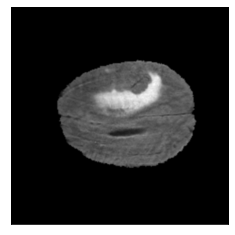

In [70]:
test_img_feat_dir = os.path.join("..","data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_flair.nii.gz")
img_feat = nib.load(test_img_feat_dir)
imgarr_feat = img_feat.get_fdata()
test_img_feat_slice = imgarr_feat[:,:,100]
test_img = np.zeros((240, 240 ,3), np.float32)

test_img[:,:,0] = test_img_feat_slice
test_img[:,:,1] = test_img_feat_slice
test_img[:,:,2] = test_img_feat_slice

plt.imshow(test_img[:,:,0], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

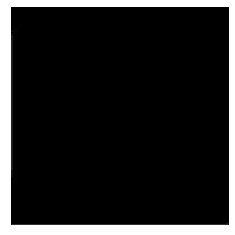

In [105]:
directory_predicted = os.path.join("..","data","test_images","3_Y_predicted.jpg")
directory_y = os.path.join("..","data","test_images","Y_truth.jpg")
directory_X = os.path.join("..","data","test_images","X_input.jpg")

img = cv2.imread(directory_predicted,0)

plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

____

In [ ]:
import SimpleITK as sitk
img_flair = sitk.ReadImage(os.path.join("..", "data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_flair.nii.gz"))
nda_flair = sitk.GetArrayViewFromImage(img_flair)
print(np.shape(nda_flair))

for i in range(len(nda_flair[:,1,1])):

    X_new = np.zeros((240, 240 ,3), np.float32)

    X_new[:,:,0] = batch_x[:,:,i]
    X_new[:,:,1] = batch_x[:,:,i]
    X_new[:,:,2] = batch_x[:,:,i]

    train_image.append(X_new)

In [ ]:
def generator():
    
    data_length = len(X_nib.get_fdata()[1,1,:])
    chunks = np.floor(data_length / batch_size)
    print('A')
    X = X_nib.get_fdata()
    y = y_nib.get_fdata()
    print('B')
    X /= 255
    y /= 255
    print('C')
    
    while True:
        
        for i in range(int(chunks)):
            X_yield = []
            y_yield = []

            X_mod = X[:,:,i*32:(i+1)*32]
            y_mod = y[:,:,i*32:(i+1)*32]
            print(np.shape(X_mod))

            for j in range(32):
                X_new = np.zeros((240, 240 ,3), np.uint8)
                X_new[:,:,0] = X_mod[:,:,j]
                X_new[:,:,1] = X_mod[:,:,j]
                X_new[:,:,2] = X_mod[:,:,j]

                X_yield.append(X_new)
                print(np.shape(X_yield))

                y_new = np.zeros((240, 240 ,3), np.uint8)
                y_new[:,:,0] = y_mod[:,:,j]
                y_new[:,:,1] = y_mod[:,:,j]
                y_new[:,:,2] = y_mod[:,:,j]

                y_yield.append(y_new)

            yield np.reshape(X_yield,(32,240,240,3)), np.reshape(y_yield,(32,240,240,3))
        

my_generator = generator()